# Monoclonal Antibody Trial Success Prediction - Data Exploration

This notebook explores clinical trial data to predict Phase 2/3 success for monoclonal antibody therapies.

**Data source:** ClinicalTrials.gov API  
**Target:** Binary classification of trial outcomes (success/failure)

In [33]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Collection (Antibody-Focused)

We'll collect clinical trial data using the ClinicalTrials.gov API and **filter for monoclonal antibody trials only**.

In [34]:
from data_collection import ClinicalTrialsAPI

# Initialize API client
api = ClinicalTrialsAPI(output_dir="../data")

# Query parameters for Phase 2 and 3 trials with definitive outcomes
# Filter at API level to only download trials with clear success/failure status
query_params = {
    "query.term": (
        "(AREA[Phase]PHASE2 OR AREA[Phase]PHASE3) AND "
        "("
        "AREA[OverallStatus]COMPLETED OR "
        "AREA[OverallStatus]TERMINATED OR "
        "AREA[OverallStatus]WITHDRAWN OR "
        "AREA[OverallStatus]SUSPENDED OR "
        "AREA[OverallStatus]APPROVED_FOR_MARKETING OR "
        "AREA[OverallStatus]AVAILABLE OR "
        "AREA[OverallStatus]NO_LONGER_AVAILABLE"
        ")"
    )
}

print("Fetching clinical trials data...")
print("This may take a few minutes...")

# Fetch studies
studies = api.search_studies(query_params=query_params, max_studies=50000)

print(f"\nCollected {len(studies)} total studies")

Fetching clinical trials data...
This may take a few minutes...
Fetching studies from ClinicalTrials.gov...
Retrieved 100 studies so far...
Retrieved 200 studies so far...
Retrieved 300 studies so far...
Retrieved 400 studies so far...
Retrieved 500 studies so far...
Retrieved 600 studies so far...
Retrieved 700 studies so far...
Retrieved 800 studies so far...
Retrieved 900 studies so far...
Retrieved 1000 studies so far...
Retrieved 1100 studies so far...
Retrieved 1200 studies so far...
Retrieved 1300 studies so far...
Retrieved 1400 studies so far...
Retrieved 1500 studies so far...
Retrieved 1600 studies so far...
Retrieved 1700 studies so far...
Retrieved 1800 studies so far...
Retrieved 1900 studies so far...
Retrieved 2000 studies so far...
Retrieved 2100 studies so far...
Retrieved 2200 studies so far...
Retrieved 2300 studies so far...
Retrieved 2400 studies so far...
Retrieved 2500 studies so far...
Retrieved 2600 studies so far...
Retrieved 2700 studies so far...
Retrieved 

In [35]:
# Convert studies to DataFrame and save
df = api.save_studies_to_csv(studies, "phase2_3_trials.csv")

# Also save raw JSON for detailed analysis
api.save_raw_json(studies, "phase2_3_trials_raw.json")

print(f"Data saved successfully!")
print(f"DataFrame shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Extracting features from 50000 studies...
Saved 50000 studies to ../data/phase2_3_trials.csv
Saved raw data for 50000 studies to ../data/phase2_3_trials_raw.json
Data saved successfully!
DataFrame shape: (50000, 17)

Columns: ['nct_id', 'brief_title', 'overall_status', 'start_date', 'completion_date', 'study_type', 'phases', 'enrollment', 'conditions', 'intervention_types', 'intervention_names', 'is_antibody', 'antibody_name', 'antibody_type', 'sponsor_name', 'sponsor_class', 'has_results']


## 2. Initial Data Exploration

In [36]:
# Display first few rows
df.head(10)

,nct_id,brief_title,overall_status,start_date,completion_date,study_type,phases,enrollment,conditions,intervention_types,intervention_names,is_antibody,antibody_name,antibody_type,sponsor_name,sponsor_class,has_results
0,NCT04029038,Modified Immune Cells (CD19-CD22 CAR T Cells) ...,WITHDRAWN,2019-05-15,2022-11-16,INTERVENTIONAL,"PHASE1,PHASE2",0,"CD19 Positive,CD22 Positive,Minimal Residual D...","BIOLOGICAL,DRUG",Autologous CD19/CD22 Chimeric Antigen Receptor...,False,,not_antibody,M.D. Anderson Cancer Center,OTHER,False
1,NCT03255226,"Efficacy, Safety, Pharmacokinetics, and Pharma...",COMPLETED,2018-03-07,2021-07-15,INTERVENTIONAL,PHASE3,60,Pediatric Congestive Heart Failure (CHF) Patie...,DRUG,Tolvaptan,False,,not_antibody,"Otsuka Pharmaceutical Co., Ltd.",INDUSTRY,True
2,NCT01134926,Non Surgical Management for Uterine Residua Af...,TERMINATED,2010-06,2012-05,INTERVENTIONAL,PHASE2,23,Intra-uterine Residua,DRUG,misoprostol,False,,not_antibody,"HaEmek Medical Center, Israel",OTHER,False
3,NCT01926678,Efficacy of Swedish Massage Therapy on Cancer-...,COMPLETED,2013-11,2016-05,INTERVENTIONAL,PHASE2,66,Cancer Related Fatigue,OTHER,"Swedish massage therapy,Light touch therapy",False,,not_antibody,Emory University,OTHER,False
4,NCT01184378,Tolerance and Digestibility of a New Formula i...,COMPLETED,2008-11,2011-01,INTERVENTIONAL,PHASE2,100,"Steatorrhea,Growth",DIETARY_SUPPLEMENT,dairy lipids and soluble milk proteins,False,,not_antibody,Lactalis,INDUSTRY,False
5,NCT03471078,Avatrombopag for the Treatment of Chemotherapy...,COMPLETED,2018-10-12,2023-01-31,INTERVENTIONAL,PHASE3,122,Chemotherapy-induced Thrombocytopenia,DRUG,"Avatrombopag,Placebo Oral Tablet",False,,not_antibody,"Sobi, Inc.",INDUSTRY,True
6,NCT00003638,Vaccine Therapy in Treating Women With Metasta...,COMPLETED,1999-01,2008-12,INTERVENTIONAL,PHASE3,950,Breast Cancer,"BIOLOGICAL,DRUG","Detox-B adjuvant,THERATOPE STn-KLH vaccine,key...",False,,not_antibody,Oncothyreon Canada Inc.,INDUSTRY,False
7,NCT01480258,"Safety, Tolerability, and Immunogenicity of V4...",COMPLETED,2011-11-23,2013-10-09,INTERVENTIONAL,PHASE3,1315,"Bacterial Infections,Virus Diseases",BIOLOGICAL,"PR5I,Rotavirus vaccine,Prevenar 13™,INFANRIX™ ...",False,,not_antibody,MCM Vaccines B.V.,INDUSTRY,True
8,NCT02400385,A Phase II Trial of Sunitinib and Nivolumab fo...,WITHDRAWN,2014-10,2015-12,INTERVENTIONAL,PHASE2,0,Melanoma,DRUG,"sunitinib,nivolumab",True,nivolumab,fully_human,California Pacific Medical Center Research Ins...,OTHER,False
9,NCT01650285,Cabazitaxel and Radiation For Patients With Pr...,TERMINATED,2013-01,2014-07,INTERVENTIONAL,PHASE2,5,Prostate Cancer,DRUG,Cabazitaxel,False,,not_antibody,Brown University,OTHER,True


In [37]:
# Basic information
print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset Information:
Shape: (50000, 17)

Columns: ['nct_id', 'brief_title', 'overall_status', 'start_date', 'completion_date', 'study_type', 'phases', 'enrollment', 'conditions', 'intervention_types', 'intervention_names', 'is_antibody', 'antibody_name', 'antibody_type', 'sponsor_name', 'sponsor_class', 'has_results']

Data types:
nct_id                object
brief_title           object
overall_status        object
start_date            object
completion_date       object
study_type            object
phases                object
enrollment             int64
conditions            object
intervention_types    object
intervention_names    object
is_antibody             bool
antibody_name         object
antibody_type         object
sponsor_name          object
sponsor_class         object
has_results             bool
dtype: object

Missing values:
nct_id                0
brief_title           0
overall_status        0
start_date            0
completion_date       0
study_type            0

In [38]:
# Summary statistics
df.describe()

,enrollment
count,50000.000000
mean,294.618400
std,2887.165429
min,0.000000
25%,23.000000
50%,65.000000
75%,203.000000
max,477102.000000


## 3. Status Distribution

In [ ]:
# Overall status distribution
plt.figure(figsize=(12, 6))
status_counts = df['overall_status'].value_counts()
sns.barplot(x=status_counts.values, y=status_counts.index, hue=status_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Clinical Trial Status', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.tight_layout()
plt.show()

print("\nStatus Distribution:")
print(status_counts)

## 4. Phase Distribution

In [ ]:
# Phase distribution
plt.figure(figsize=(10, 6))
phase_counts = df['phases'].value_counts()
sns.barplot(x=phase_counts.values, y=phase_counts.index, hue=phase_counts.index, palette='coolwarm', legend=False)
plt.title('Distribution of Clinical Trial Phases', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Phase', fontsize=12)
plt.tight_layout()
plt.show()

print("\nPhase Distribution:")
print(phase_counts)

## 5. Sponsor Analysis

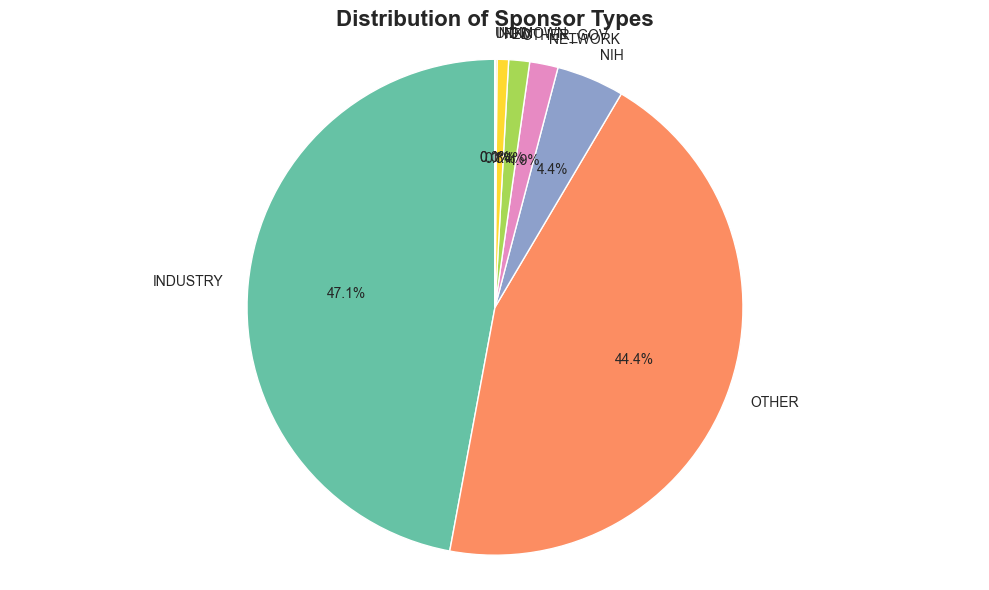


Sponsor Class Distribution:
sponsor_class
INDUSTRY     23539
OTHER        22208
NIH           2207
NETWORK        926
OTHER_GOV      680
FED            375
INDIV           61
UNKNOWN          4
Name: count, dtype: int64

Percentages:
sponsor_class
INDUSTRY     47.078
OTHER        44.416
NIH           4.414
NETWORK       1.852
OTHER_GOV     1.360
FED           0.750
INDIV         0.122
UNKNOWN       0.008
Name: proportion, dtype: float64


In [41]:
# Sponsor class distribution
plt.figure(figsize=(10, 6))
sponsor_counts = df['sponsor_class'].value_counts()
colors = sns.color_palette('Set2', len(sponsor_counts))
plt.pie(sponsor_counts.values, labels=sponsor_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors)
plt.title('Distribution of Sponsor Types', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("\nSponsor Class Distribution:")
print(sponsor_counts)
print(f"\nPercentages:")
print(df['sponsor_class'].value_counts(normalize=True) * 100)

## 6. Enrollment Analysis

Enrollment Statistics:
count     50000.000000
mean        294.618400
std        2887.165429
min           0.000000
25%          23.000000
50%          65.000000
75%         203.000000
max      477102.000000
Name: enrollment, dtype: float64


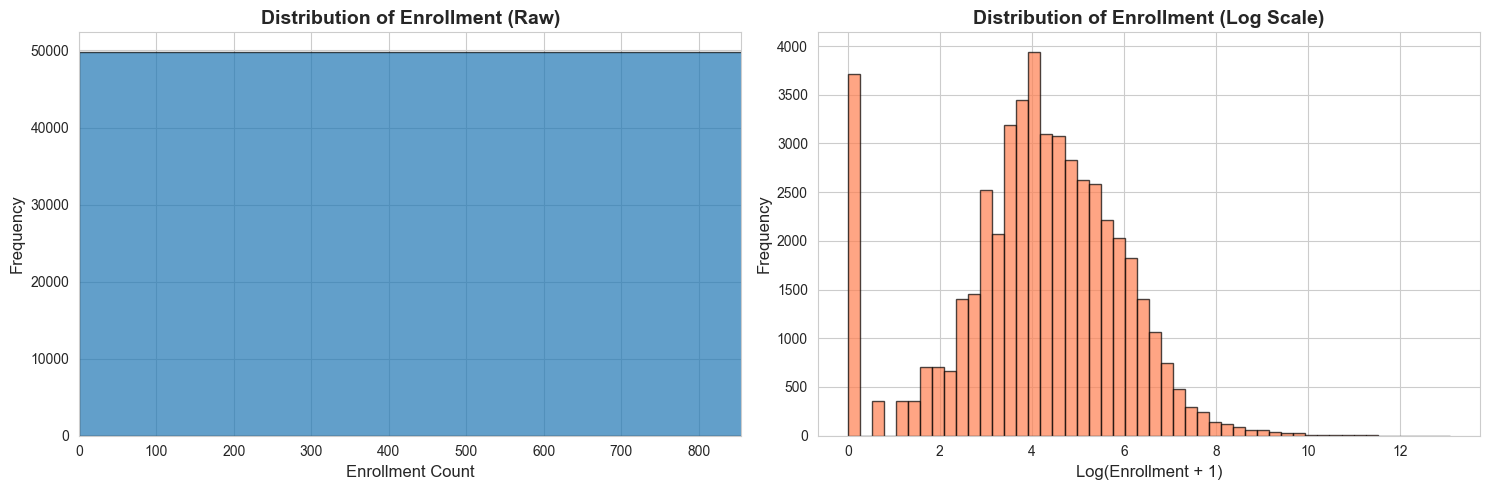

In [42]:
# Enrollment statistics
df['enrollment'] = pd.to_numeric(df['enrollment'], errors='coerce')

print("Enrollment Statistics:")
print(df['enrollment'].describe())

# Plot enrollment distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df['enrollment'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Enrollment Count', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Enrollment (Raw)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, df['enrollment'].quantile(0.95))

# Log-scale histogram
axes[1].hist(np.log1p(df['enrollment'].dropna()), bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Log(Enrollment + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Enrollment (Log Scale)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Temporal Analysis

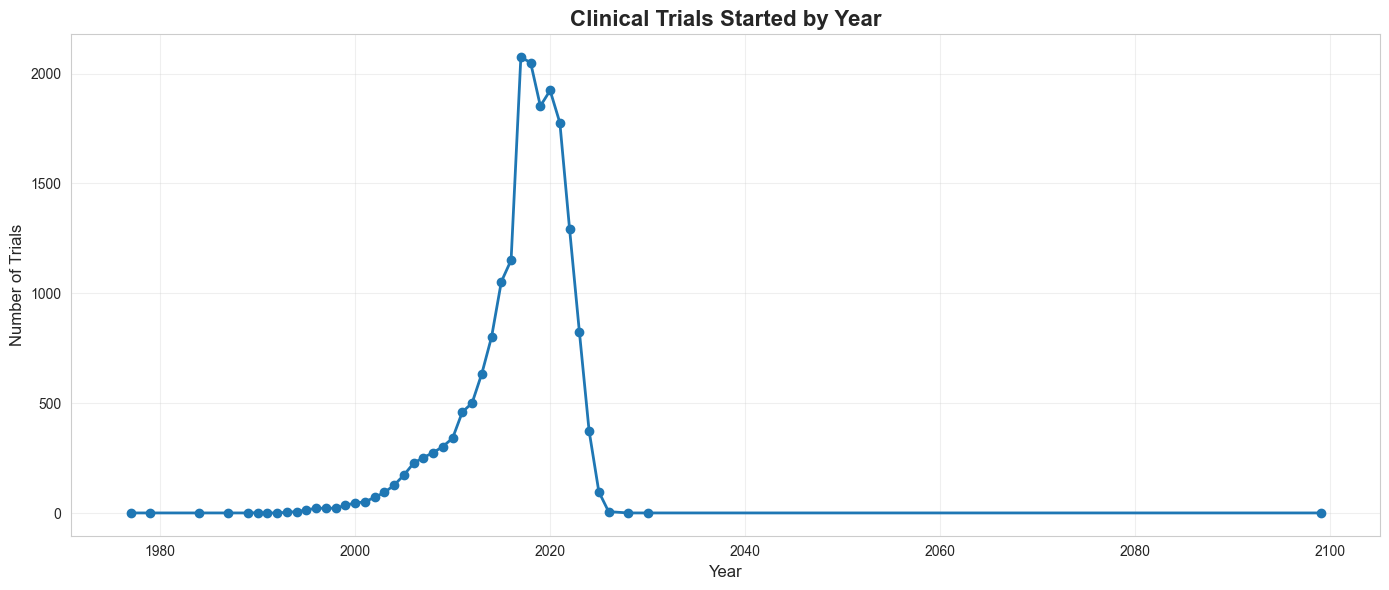


Trials by Decade:
decade
1970.0        2
1980.0        3
1990.0      132
2000.0     1622
2010.0    10919
2020.0     6295
2030.0        1
2090.0        1
Name: count, dtype: int64


In [43]:
# Convert dates
df['start_date_parsed'] = pd.to_datetime(df['start_date'], errors='coerce')
df['start_year'] = df['start_date_parsed'].dt.year

# Trials over time
plt.figure(figsize=(14, 6))
trials_by_year = df['start_year'].value_counts().sort_index()
plt.plot(trials_by_year.index, trials_by_year.values, marker='o', linewidth=2, markersize=6)
plt.title('Clinical Trials Started by Year', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Trials', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTrials by Decade:")
df['decade'] = (df['start_year'] // 10) * 10
print(df['decade'].value_counts().sort_index())

## 8. Condition Analysis

In [ ]:
# Extract individual conditions
all_conditions = []
for conditions in df['conditions'].dropna():
    all_conditions.extend([c.strip() for c in conditions.split(',')])

condition_counts = pd.Series(all_conditions).value_counts()

print(f"Total unique conditions: {len(condition_counts)}")
print(f"\nTop 20 Most Common Conditions:")

# Plot top 20 conditions
plt.figure(figsize=(12, 8))
top_conditions = condition_counts.head(20)
sns.barplot(y=top_conditions.index, x=top_conditions.values, hue=top_conditions.index, palette='mako', legend=False)
plt.title('Top 20 Most Common Conditions in Clinical Trials', fontsize=16, fontweight='bold')
plt.xlabel('Number of Trials', fontsize=12)
plt.ylabel('Condition', fontsize=12)
plt.tight_layout()
plt.show()

print(top_conditions)

## 9. Intervention Type Analysis

Intervention Type Distribution:
DRUG                   40074
BIOLOGICAL              6016
OTHER                   4685
PROCEDURE               3156
DEVICE                  1923
BEHAVIORAL              1612
RADIATION               1426
DIETARY_SUPPLEMENT      1009
COMBINATION_PRODUCT      292
GENETIC                  195
DIAGNOSTIC_TEST           84
Name: count, dtype: int64


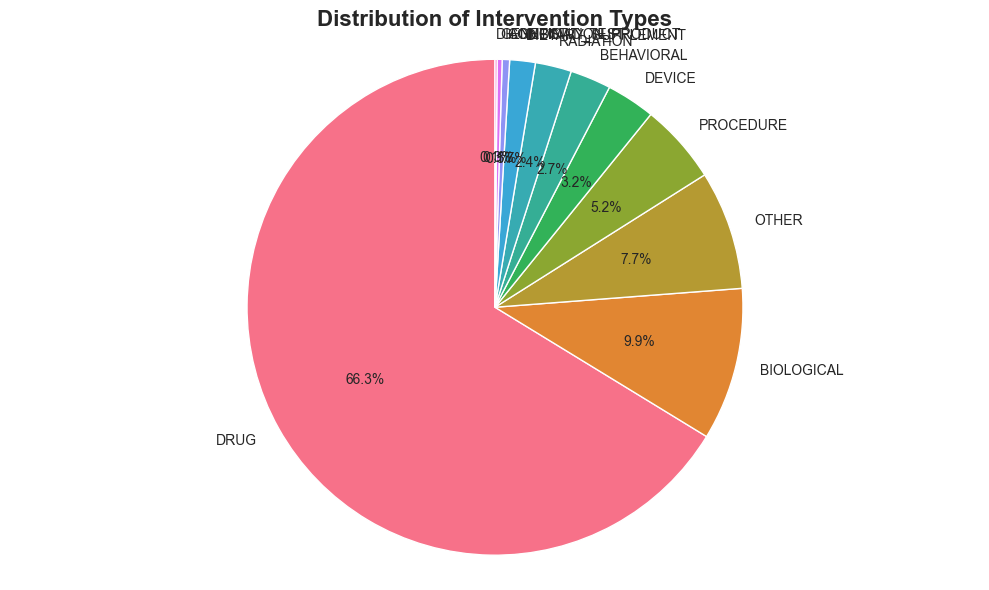

In [45]:
# Extract intervention types
all_interventions = []
for interventions in df['intervention_types'].dropna():
    all_interventions.extend([i.strip() for i in interventions.split(',')])

intervention_counts = pd.Series(all_interventions).value_counts()

print("Intervention Type Distribution:")
print(intervention_counts)

# Plot
plt.figure(figsize=(10, 6))
colors = sns.color_palette('husl', len(intervention_counts))
plt.pie(intervention_counts.values, labels=intervention_counts.index,
        autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Intervention Types', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 10. Antibody-Specific Insights Summary

In [ ]:
print("=" * 70)
print("KEY INSIGHTS FROM ANTIBODY TRIAL EXPLORATION")
print("=" * 70)

print(f"\n1. Dataset Overview:")
print(f"   - Total antibody trials: {len(df):,}")
print(f"   - Features collected: {len(df.columns)}")
print(f"   - Date range: {df['start_year'].min():.0f} - {df['start_year'].max():.0f}")

print(f"\n2. Antibody Types:")
if 'antibody_type' in df.columns:
    antibody_pct = df['antibody_type'].value_counts(normalize=True) * 100
    for ab_type, pct in antibody_pct.items():
        print(f"   - {ab_type}: {pct:.1f}%")

print(f"\n3. Trial Status:")
print(f"   - Completed: {(df['overall_status'] == 'COMPLETED').sum():,} ({(df['overall_status'] == 'COMPLETED').sum() / len(df) * 100:.1f}%)")
print(f"   - Terminated: {(df['overall_status'] == 'TERMINATED').sum():,} ({(df['overall_status'] == 'TERMINATED').sum() / len(df) * 100:.1f}%)")
print(f"   - Withdrawn: {(df['overall_status'] == 'WITHDRAWN').sum():,} ({(df['overall_status'] == 'WITHDRAWN').sum() / len(df) * 100:.1f}%)")

print(f"\n4. Phase Distribution:")
phase_pct = df['phases'].value_counts(normalize=True) * 100
for phase, pct in phase_pct.items():
    print(f"   - {phase}: {pct:.1f}%")

print(f"\n5. Sponsor Insights:")
sponsor_pct = df['sponsor_class'].value_counts(normalize=True) * 100
for sponsor, pct in sponsor_pct.items():
    print(f"   - {sponsor}: {pct:.1f}%")

print(f"\n6. Antibody-Specific Insights:")
if 'target_mechanism' in df.columns:
    print(f"   - Checkpoint inhibitors: {(df['target_mechanism'] == 'Checkpoint Inhibitor').sum()} trials")
if 'has_biomarker_selection' in df.columns:
    print(f"   - Biomarker-selected trials: {df['has_biomarker_selection'].sum()} ({df['has_biomarker_selection'].sum()/len(df)*100:.1f}%)")
if 'is_combination' in df.columns:
    print(f"   - Combination therapy: {df['is_combination'].sum()} ({df['is_combination'].sum()/len(df)*100:.1f}%)")

print(f"\n7. Enrollment:")
print(f"   - Median enrollment: {df['enrollment'].median():.0f}")
print(f"   - Mean enrollment: {df['enrollment'].mean():.0f}")
print(f"   - Max enrollment: {df['enrollment'].max():.0f}")

print("\n" + "=" * 70)
print("COMPLETED ANALYSIS PIPELINE:")
print("=" * 70)
print("✓ Labeled antibody trials as success/failure based on status")
print("✓ Engineered antibody-specific features (type, target, biomarkers)")
print("✓ Built and evaluated prediction models (Gradient Boosting ROC AUC: 0.786)")
print("✓ Analyzed which antibody characteristics predict success")
print("✓ Compared antibody types and mechanisms (see reports/ for full results)")

## 11. Save Processed Data

In [47]:
# Save the explored antibody dataset
df.to_csv('../data/antibody_trials_explored.csv', index=False)
print("Antibody data saved to ../data/antibody_trials_explored.csv")
print(f"\nDataset ready for labeling and feature engineering!")

Antibody data saved to ../data/antibody_trials_explored.csv

Dataset ready for labeling and feature engineering!


## 12. Cross-Analysis: Phase vs Status

Phase vs Status (% within each phase):
overall_status  COMPLETED  SUSPENDED  TERMINATED  WITHDRAWN
phases                                                     
PHASE1,PHASE2       72.56       1.00       18.51       7.93
PHASE2              77.30       0.50       16.21       5.99
PHASE2,PHASE3       79.09       1.00       14.09       5.82
PHASE3              84.93       0.34       11.03       3.70


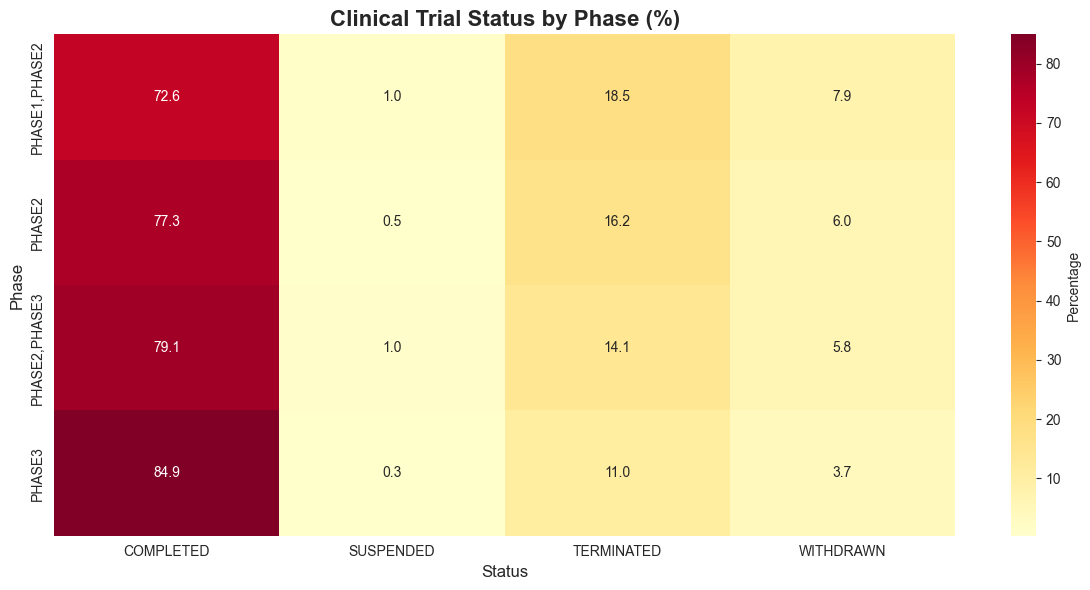

In [48]:
# Create crosstab
phase_status_crosstab = pd.crosstab(df['phases'], df['overall_status'], normalize='index') * 100

print("Phase vs Status (% within each phase):")
print(phase_status_crosstab.round(2))

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(phase_status_crosstab, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage'})
plt.title('Clinical Trial Status by Phase (%)', fontsize=16, fontweight='bold')
plt.xlabel('Status', fontsize=12)
plt.ylabel('Phase', fontsize=12)
plt.tight_layout()
plt.show()